In [1]:
import pandas as pd

train_dataframe = pd.read_csv('/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data_train.csv')
val_dataframe = pd.read_csv('/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data_eval.csv')

Text(0, 0.5, 'Count')

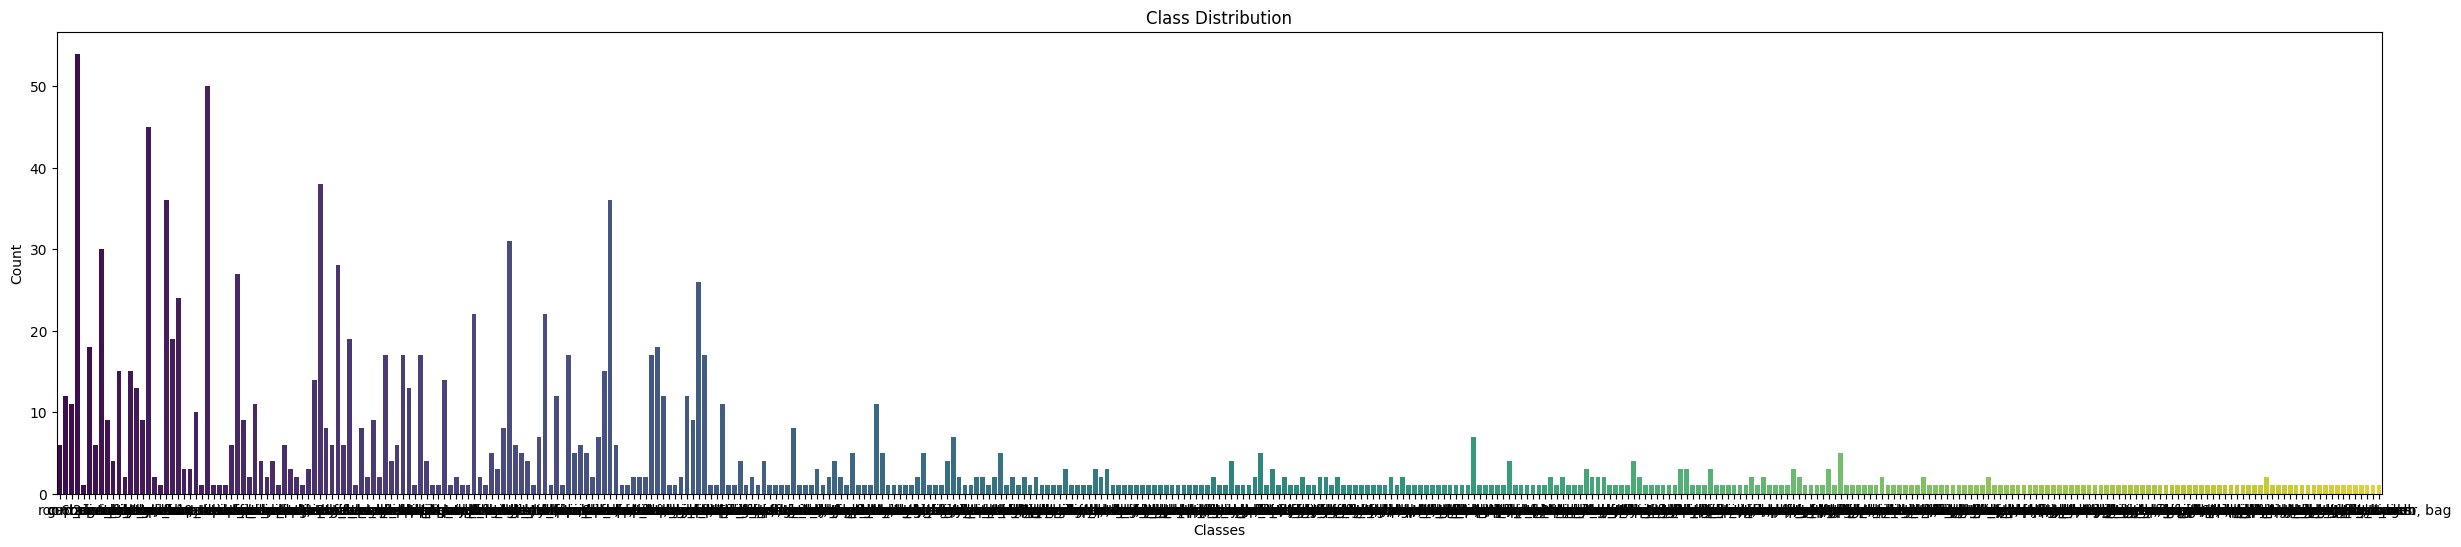

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 6))
sns.countplot(x='answer', data=train_dataframe[:1500], palette='viridis')

plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

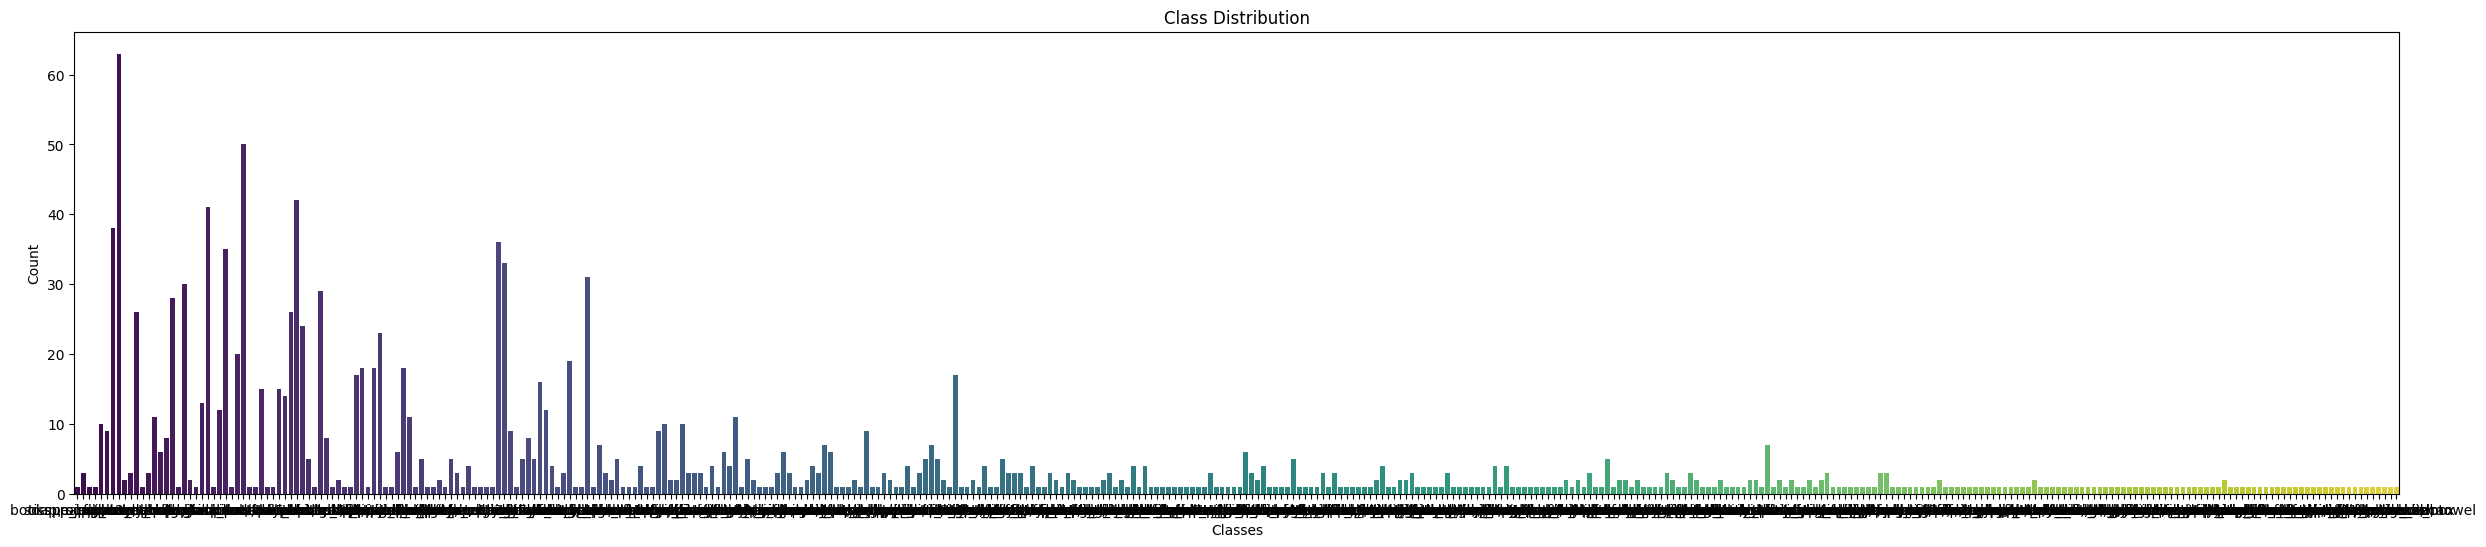

In [3]:
plt.figure(figsize=(30, 6))
sns.countplot(x='answer', data=train_dataframe[1500:3000], palette='viridis')

plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')

In [4]:
answer_freq = {}

for answer in train_dataframe['answer']:
    if answer not in answer_freq:
        answer_freq[answer] = 1
    else:
        answer_freq[answer] += 1
        
answer_freq = dict(sorted(answer_freq.items(), key=lambda item: item[1], reverse=True))

print('Frequency of classes in descending order:')
print(answer_freq) 

Frequency of classes in descending order:
{'2': 442, 'table': 346, 'chair': 293, '3': 257, 'window': 227, 'white': 213, 'photo': 204, 'cabinet': 199, 'sofa': 189, '1': 188, 'lamp': 185, 'bed': 183, 'picture': 177, '4': 155, 'door': 154, 'books': 144, 'brown': 128, 'garbage_bin': 124, 'mirror': 118, 'red': 112, 'television': 111, 'pillow': 111, 'black': 101, 'towel': 98, 'blinds': 95, 'clothes': 95, 'shelves': 87, 'curtain': 84, 'bookshelf': 84, '5': 83, 'blue': 80, 'bag': 77, '6': 76, 'refridgerator': 72, 'sink': 69, 'paper': 68, 'stool': 61, 'floor_mat': 60, 'book': 58, 'bottle_of_liquid': 56, 'tissue_roll': 56, 'microwave': 52, 'green': 50, 'wall_decoration': 49, 'pink': 49, 'night_stand': 48, 'cup': 46, 'bottle': 44, 'tissue_box': 43, 'vase': 42, 'printer': 42, 'decorative_item': 42, 'stove': 41, 'light': 41, 'monitor': 39, 'ornamental_plant': 38, 'toilet': 38, 'basket': 36, 'toy': 35, '8': 34, '7': 34, 'whiteboard': 34, 'bathtub': 34, 'ladder': 33, 'box': 32, 'plant': 31, 'telephon

In [5]:
unique_answers = set()

for answer in train_dataframe['answer']:
    if answer not in unique_answers:
        unique_answers.add(answer)
        
print(f"Number of unique answers in train data= {len(unique_answers)}")

answer_to_index = {}
index_to_answer = {}

i = 0
for answer in unique_answers:
    answer_to_index[answer] = i
    index_to_answer[i] = answer
    i += 1

answer_to_index['unk'] = i
index_to_answer[i] = 'unk'

print(f"Total number of classes = {len(answer_to_index)}")


Number of unique answers in train data= 1260
Total number of classes = 1261


In [6]:
class_weights = []

for key, _ in answer_to_index.items():
    if key != 'unk':
        class_weights.append(1/answer_freq[key])
    else:
        class_weights.append(1.0)

In [7]:
import numpy as np

def class_to_index(answer):
    if answer in answer_to_index:
        index = answer_to_index[answer]
    else:
        index = answer_to_index['unk']
    return index

In [8]:
train_dataframe['image_path'] = train_dataframe['image_id'].apply(lambda x: f"/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/{x}.png")
train_dataframe['answer_index'] = train_dataframe['answer'].apply(lambda x: class_to_index(x))
val_dataframe['image_path'] = val_dataframe['image_id'].apply(lambda x: f"/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/{x}.png")

In [9]:
val_dataframe['answer_index'] = val_dataframe['answer'].apply(lambda x: class_to_index(x))

In [10]:
train_dataframe.head()

,question,answer,image_id,image_path,answer_index
0,what is the object on the shelves,cup,image100,/kaggle/input/visual-question-answering-comput...,633
1,how man chairs are there,6,image888,/kaggle/input/visual-question-answering-comput...,168
2,what is hanged to the right side of the bed,curtain,image1174,/kaggle/input/visual-question-answering-comput...,106
3,how many picture are on the wall,2,image942,/kaggle/input/visual-question-answering-comput...,1228
4,what is the object on the floor behind the rack,room_divider,image1220,/kaggle/input/visual-question-answering-comput...,951


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

class VQADataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        question = self.dataframe.iloc[idx]['question']
        answer = self.dataframe.iloc[idx]['answer_index']
        image_path = self.dataframe.iloc[idx]['image_path']
        
        return image_path, question, answer
train_dataset = VQADataset(train_dataframe)
val_dataset = VQADataset(val_dataframe)

training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True)

In [12]:
import torch
from torchvision import models, transforms
from transformers import BertModel, BertTokenizer
from PIL import Image

class VQAModel(torch.nn.Module):
    def __init__(self):
        super(VQAModel, self).__init__()
        
        resnet = models.resnet50(pretrained=True)
        self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
        
        for param in self.resnet.parameters():
            param.requires_grad = False
        for param in self.resnet[-2].parameters():
            param.requires_grad = True
        
        self.resnet_preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        model_name = "bert-base-uncased"
        self.bert_tokenizer = BertTokenizer.from_pretrained(model_name)
        self.bert_model = BertModel.from_pretrained(model_name)
        
        for param in self.bert_model.parameters():
            param.requires_grad = False
        for layer in self.bert_model.encoder.layer[-2:]:
            for param in layer.parameters():
                param.requires_grad = True
            
        self.activation = torch.nn.ReLU()
        
        self.conv1 = torch.nn.Conv2d(in_channels=2048, out_channels=1024, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        
        self.linear1 = torch.nn.Linear(1024, 3500)
        self.batch_norm1 = torch.nn.BatchNorm1d(3500) 
        
        self.linear2 = torch.nn.Linear(3500, 4500)
        self.batch_norm2 = torch.nn.BatchNorm1d(4500) 
        
        self.linear3 = torch.nn.Linear(4500, 2000)
        self.batch_norm3 = torch.nn.BatchNorm1d(2000) 
        
        self.linear4 = torch.nn.Linear(2000, 1261)
    
    def forward(self, image_paths, questions):
        images = []
        for path in image_paths:
            image = Image.open(path).convert('RGB')
            image = self.resnet_preprocess(image)  
            images.append(image)
        
        images = torch.stack(images).to(next(self.parameters()).device)
        image_features = self.resnet(images)
        image_features = image_features.view(images.size(0), 2048, 1, 1)
        
        x = self.activation(self.conv1(image_features))
        x = self.pool(x)
        x = self.activation(self.conv2(x))
        x = self.pool(x)
        x = self.activation(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        
        inputs = self.bert_tokenizer(questions, return_tensors='pt', padding=True, truncation=True, max_length=32, return_attention_mask=True)
        for key, val in inputs.items():
            inputs[key] = val.to(images.device)
        
        question_features = self.bert_model(**inputs).pooler_output
        
        combined_features = torch.cat((x, question_features), dim=1)
        
        if x.shape[0] == 1:
            x = self.linear1(combined_features)
            x = self.activation(x)
            x = self.linear2(x)
            x = self.activation(x)
            x = self.linear3(x)
            x = self.activation(x)
            x = self.linear4(x)
        else:    
            x = self.linear1(combined_features)
            x = self.batch_norm1(x)
            x = self.activation(x)
            x = self.linear2(x)
            x = self.batch_norm2(x)
            x = self.activation(x)
            x = self.linear3(x)
            x = self.batch_norm3(x)
            x = self.activation(x)
            x = self.linear4(x)
        
        return x
    
    def predict(self, image_path, question):
        self.eval()  
        
        image = Image.open(image_path).convert('RGB')
        image = self.resnet_preprocess(image)  
        image = image.unsqueeze(0).to(next(self.parameters()).device)
        
        with torch.no_grad():  
            image_features = self.resnet(image)  
            image_features = image_features.view(image_features.size(0), 2048, 1, 1)  
            
            x = self.activation(self.conv1(image_features))
            x = self.pool(x)
            x = self.activation(self.conv2(x))
            x = self.pool(x)
            x = self.activation(self.conv3(x))
            x = self.pool(x)
            x = x.view(x.size(0), -1)  

            inputs = self.bert_tokenizer(question, return_tensors='pt', padding=True, truncation=True, max_length=32, return_attention_mask=True)
            for key, val in inputs.items():
                inputs[key] = val.to(image.device)
            
            question_features = self.bert_model(**inputs).pooler_output
            
            combined_features = torch.cat((x, question_features), dim=1)
            x = self.linear1(combined_features)
            x = self.batch_norm1(x)
            x = self.activation(x)
            x = self.linear2(x)
            x = self.batch_norm2(x)
            x = self.activation(x)
            x = self.linear3(x)
            x = self.batch_norm3(x)
            x = self.activation(x)
            x = self.linear4(x)
            
            _, predicted_answer = torch.max(x, dim=1)

        return index_to_answer[predicted_answer.item()]

                                      
        


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VQAModel()
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s] 


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

VQAModel(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 

In [14]:
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights).float().to(device))

In [15]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [16]:
print(model.resnet[-2])

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

In [17]:
from torchsummary import summary
summary(model.resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [18]:
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

max_learning_rate = 1e-2

optimizer = torch.optim.Adam(model.parameters(), lr=max_learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1s = []

val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

num_epochs = 15 

for epoch in range(num_epochs):
    model.train()  
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    all_train_labels = []
    all_train_predictions = []
    
    for batch_idx, (image_paths, questions, answers) in enumerate(tqdm(training_loader, desc=f'Training Epoch {epoch + 1}/{num_epochs}')):
        optimizer.zero_grad() 
        outputs = model(image_paths, questions)
        answers_tensor = answers.to(device)
        loss = criterion(outputs, answers_tensor)
        total_train_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == answers_tensor).sum().item()
        total_train += answers_tensor.size(0)
        
        all_train_predictions.extend(predicted.cpu().numpy())
        all_train_labels.extend(answers_tensor.cpu().numpy())
        
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_train_loss / len(training_loader)
    train_accuracy = correct_train / total_train
    train_precision = precision_score(all_train_labels, all_train_predictions, average='weighted', zero_division=1)
    train_recall = recall_score(all_train_labels, all_train_predictions, average='weighted', zero_division=1)
    train_f1 = f1_score(all_train_labels, all_train_predictions, average='weighted', zero_division=1)
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy * 100)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy*100:.4f}%, Learning Rate: {optimizer.param_groups[0]['lr']}")

    model.eval()  
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    all_val_labels = []
    all_val_predictions = []
    
    with torch.no_grad():
        for batch_idx, (image_paths, questions, answers) in enumerate(tqdm(validation_loader, desc=f'Validation Epoch {epoch + 1}/{num_epochs}')):
            outputs = model(image_paths, questions)
            answers_tensor = answers.to(device)
            loss = criterion(outputs, answers_tensor)
            total_val_loss += loss.item()
    
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == answers_tensor).sum().item()
            total_val += answers_tensor.size(0)
    
            all_val_predictions.extend(predicted.cpu().numpy())
            all_val_labels.extend(answers_tensor.cpu().numpy())
    
    avg_val_loss = total_val_loss / len(validation_loader)
    val_accuracy = correct_val / total_val
    val_precision = precision_score(all_val_labels, all_val_predictions, average='weighted', zero_division=1)
    val_recall = recall_score(all_val_labels, all_val_predictions, average='weighted', zero_division=1)
    val_f1 = f1_score(all_val_labels, all_val_predictions, average='weighted', zero_division=1)
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy * 100)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy*100:.4f}%')

    scheduler.step(avg_train_loss)

final_train_precision = sum(train_precisions) / len(train_precisions)
final_train_recall = sum(train_recalls) / len(train_recalls)
final_train_f1 = sum(train_f1s) / len(train_f1s)

final_val_precision = sum(val_precisions) / len(val_precisions)
final_val_recall = sum(val_recalls) / len(val_recalls)
final_val_f1 = sum(val_f1s) / len(val_f1s)

print(f"Final Training Precision: {final_train_precision:.4f}, "
      f"Training Recall: {final_train_recall:.4f}, "
      f"Training F1: {final_train_f1:.4f}")

print(f"Final Validation Precision: {final_val_precision:.4f}, "
      f"Validation Recall: {final_val_recall:.4f}, "
      f"Validation F1: {final_val_f1:.4f}")     
        
            


Training Epoch 1/15: 100%|██████████| 1247/1247 [03:15<00:00,  6.39it/s]


Epoch [1/15], Average Training Loss: 8.4954, Training Accuracy: 0.1704%, Learning Rate: 0.01


Validation Epoch 1/15: 100%|██████████| 312/312 [00:41<00:00,  7.55it/s]


Epoch [1/15], Average Validation Loss: 17.1622, Validation Accuracy: 0.8821%


Training Epoch 2/15: 100%|██████████| 1247/1247 [02:58<00:00,  7.00it/s]


Epoch [2/15], Average Training Loss: 7.3778, Training Accuracy: 0.2306%, Learning Rate: 0.01


Validation Epoch 2/15: 100%|██████████| 312/312 [00:40<00:00,  7.76it/s]


Epoch [2/15], Average Validation Loss: 15.3686, Validation Accuracy: 1.6439%


Training Epoch 3/15: 100%|██████████| 1247/1247 [02:55<00:00,  7.09it/s]


Epoch [3/15], Average Training Loss: 7.2442, Training Accuracy: 0.5113%, Learning Rate: 0.01


Validation Epoch 3/15: 100%|██████████| 312/312 [00:40<00:00,  7.62it/s]


Epoch [3/15], Average Validation Loss: 13.4756, Validation Accuracy: 0.6014%


Training Epoch 4/15: 100%|██████████| 1247/1247 [02:56<00:00,  7.06it/s]


Epoch [4/15], Average Training Loss: 7.1511, Training Accuracy: 0.8522%, Learning Rate: 0.01


Validation Epoch 4/15: 100%|██████████| 312/312 [00:40<00:00,  7.65it/s]


Epoch [4/15], Average Validation Loss: 12.4106, Validation Accuracy: 0.7217%


Training Epoch 5/15: 100%|██████████| 1247/1247 [02:53<00:00,  7.17it/s]


Epoch [5/15], Average Training Loss: 7.1405, Training Accuracy: 0.7119%, Learning Rate: 0.01


Validation Epoch 5/15: 100%|██████████| 312/312 [00:41<00:00,  7.58it/s]


Epoch [5/15], Average Validation Loss: 9.2350, Validation Accuracy: 0.6014%


Training Epoch 6/15: 100%|██████████| 1247/1247 [02:53<00:00,  7.20it/s]


Epoch [6/15], Average Training Loss: 7.0938, Training Accuracy: 0.8221%, Learning Rate: 0.01


Validation Epoch 6/15: 100%|██████████| 312/312 [00:41<00:00,  7.58it/s]


Epoch [6/15], Average Validation Loss: 9.5162, Validation Accuracy: 0.7618%


Training Epoch 7/15: 100%|██████████| 1247/1247 [02:55<00:00,  7.10it/s]


Epoch [7/15], Average Training Loss: 7.0736, Training Accuracy: 1.1229%, Learning Rate: 0.01


Validation Epoch 7/15: 100%|██████████| 312/312 [00:40<00:00,  7.64it/s]


Epoch [7/15], Average Validation Loss: 9.8153, Validation Accuracy: 0.7217%


Training Epoch 8/15: 100%|██████████| 1247/1247 [02:54<00:00,  7.17it/s]


Epoch [8/15], Average Training Loss: 7.0709, Training Accuracy: 0.7921%, Learning Rate: 0.01


Validation Epoch 8/15: 100%|██████████| 312/312 [00:40<00:00,  7.63it/s]


Epoch [8/15], Average Validation Loss: 9.8258, Validation Accuracy: 1.7241%


Training Epoch 9/15: 100%|██████████| 1247/1247 [02:53<00:00,  7.19it/s]


Epoch [9/15], Average Training Loss: 7.0684, Training Accuracy: 0.9324%, Learning Rate: 0.01


Validation Epoch 9/15: 100%|██████████| 312/312 [00:41<00:00,  7.58it/s]


Epoch [9/15], Average Validation Loss: 10.2277, Validation Accuracy: 0.5213%


Training Epoch 10/15: 100%|██████████| 1247/1247 [02:53<00:00,  7.20it/s]


Epoch [10/15], Average Training Loss: 7.0497, Training Accuracy: 1.1831%, Learning Rate: 0.01


Validation Epoch 10/15: 100%|██████████| 312/312 [00:40<00:00,  7.79it/s]


Epoch [10/15], Average Validation Loss: 10.3436, Validation Accuracy: 0.5613%


Training Epoch 11/15: 100%|██████████| 1247/1247 [02:56<00:00,  7.05it/s]


Epoch [11/15], Average Training Loss: 7.0591, Training Accuracy: 0.7620%, Learning Rate: 0.01


Validation Epoch 11/15: 100%|██████████| 312/312 [00:40<00:00,  7.77it/s]


Epoch [11/15], Average Validation Loss: 10.4652, Validation Accuracy: 0.8821%


Training Epoch 12/15: 100%|██████████| 1247/1247 [02:55<00:00,  7.10it/s]


Epoch [12/15], Average Training Loss: 7.0513, Training Accuracy: 1.1129%, Learning Rate: 0.01


Validation Epoch 12/15: 100%|██████████| 312/312 [00:40<00:00,  7.64it/s]


Epoch [12/15], Average Validation Loss: 10.6915, Validation Accuracy: 3.0072%


Training Epoch 13/15: 100%|██████████| 1247/1247 [02:56<00:00,  7.07it/s]


Epoch [13/15], Average Training Loss: 7.0797, Training Accuracy: 0.9525%, Learning Rate: 0.01


Validation Epoch 13/15: 100%|██████████| 312/312 [00:42<00:00,  7.37it/s]


Epoch [13/15], Average Validation Loss: 11.0548, Validation Accuracy: 0.8420%


Training Epoch 14/15: 100%|██████████| 1247/1247 [02:55<00:00,  7.09it/s]


Epoch [14/15], Average Training Loss: 7.0469, Training Accuracy: 0.8121%, Learning Rate: 0.01


Validation Epoch 14/15: 100%|██████████| 312/312 [00:40<00:00,  7.63it/s]


Epoch [14/15], Average Validation Loss: 11.2481, Validation Accuracy: 0.7618%


Training Epoch 15/15: 100%|██████████| 1247/1247 [02:56<00:00,  7.08it/s]


Epoch [15/15], Average Training Loss: 7.0575, Training Accuracy: 0.9725%, Learning Rate: 0.01


Validation Epoch 15/15: 100%|██████████| 312/312 [00:41<00:00,  7.58it/s]

Epoch [15/15], Average Validation Loss: 11.3233, Validation Accuracy: 1.0826%
Final Training Precision: 0.8030, Training Recall: 0.0080, Training F1: 0.0023
Final Validation Precision: 0.9837, Validation Recall: 0.0102, Validation F1: 0.0003


NameError: name 'model' is not defined